In [1]:
!pip install torch torchvision matplotlib pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

# Environment Setup

In [2]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

import torch.optim as optim


# Custom Monet Dataset

In [3]:
class monetDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = [os.path.join(path + elem) for elem in os.listdir(path) if elem[-3:]=="jpg"]
        self.transform = transform

    def __len__(self):
        return len(self.path)


    def __getitem__(self, idx):
        img_path = self.path[idx]
        img = Image.open(path)
        if self.transform:
            img = self.transform(img)
        return img
        
        
    

# Transform and DataLoader

In [4]:
myTransform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

myDataset = monetDataset("/kaggle/input/gan-getting-started/monet_jpg", myTransform)

myDataLoader = DataLoader(myDataset, batch_size = 32)



# Generator

In [5]:
class Generator(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, features=64):
        super(Generator, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.BatchNorm2d(features),
            nn.ReLU(True),

            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(features * 2),
            nn.ReLU(True),

            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(features * 4),
            nn.ReLU(True),

            nn.Conv2d(features * 4, features * 8, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(features * 8),
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(features * 8, features * 4, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(features * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features * 4, features * 2, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(features * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features * 2, features, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.BatchNorm2d(features),
            nn.ReLU(True),

            nn.ConvTranspose2d(features, out_channels, kernel_size=4, stride=2, padding=1),  # 256x256
            nn.Tanh()  # Output range [-1, 1]
        )
        
        
        
        
    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return z
        
        

# Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_channels = 1, features=64):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Input: (1, 256, 256)
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1),  # (64, 128, 128)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1),  # (128, 64, 64)
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1),  # (256, 32, 32)
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 4, features * 8, kernel_size=4, stride=2, padding=1),  # (512, 16, 16)
            nn.BatchNorm2d(features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),  # (512 * 16 * 16)
            nn.Linear(features * 8 * 16 * 16, 1),
            nn.Sigmoid()  # Output: scalar probability
        )

    def forward(self, x):
        return self.model(x)
        

# Loss and Optimizer

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# RnD

In [8]:
myGen = Generator()
input1 = torch.randn(1,1,256,256)
output = myGen(input1)

print(output.shape)

torch.Size([1, 1, 256, 256])


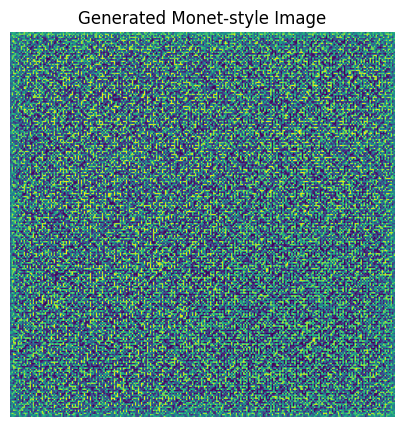

In [9]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Assume `output` is the result from generator: (batch_size, 3, 256, 256)
fake_image = output[0].detach().cpu()  # Take first image and move to CPU

# Denormalize
fake_image = (fake_image +1) /2

# Convert to numpy and plot
plt.figure(figsize=(5, 5))
plt.imshow(fake_image.permute(1, 2, 0).numpy())  # C×H×W → H×W×C
plt.axis("off")
plt.title("Generated Monet-style Image")
plt.show()

In [10]:
img = Image.open("/kaggle/input/gan-getting-started/photo_jpg/00068bc07f.jpg")

print(img.size)

(256, 256)
